Análisis de la Columna 1: "expenses"

In [1]:
# Lo primero que hacemos es importar todas las librerias necesarias.
import pandas as pd
import numpy as np

In [2]:
# Abrimos el dataset y hacemos un chequeo rápido para saber cantidad de registros y miramos la composición del mismo.
filename = "../../dataset/properati.csv"
data = pd.read_csv(filename)

display(data.sample(n=10).expenses)

88917        NaN
107184       NaN
22054        NaN
67073        NaN
87412        NaN
90021        NaN
76864     4500.0
107486       NaN
57924        NaN
44194        NaN
Name: expenses, dtype: float64

Los valores NaN los Reemplazamos por 0.

#TODO ver si con regex se puede recuperar info de otras columnas.

In [3]:
print(f'Cantidad de registros con NaN Antes: {data.expenses.isnull().sum()}')
data['expenses'] = data['expenses'].fillna(0)
print(f'Cantidad de registros con NaN Después: {data.expenses.isnull().sum()}')

Cantidad de registros con NaN Antes: 106958
Cantidad de registros con NaN Después: 0


Al ser un valor muy variable, ya que el valor de las expensas depende de muchos factores, y los valores pueden ser muy distintos, Lo primero que hacemos es analizar los rangos de valores.

In [4]:
display(data.groupby('property_type').agg({'expenses':['count', 'mean', 'max', 'min']}))

expenses                             
                 count        mean         max  min
property_type                                      
PH                5751   47.320814      6000.0  0.0
apartment        71065  788.850517  10001500.0  0.0
house            40268  353.069211   1250000.0  0.0
store             4136  215.789894     19000.0  0.0

Ahora verificamos los datos excluyendo los valores extremos.

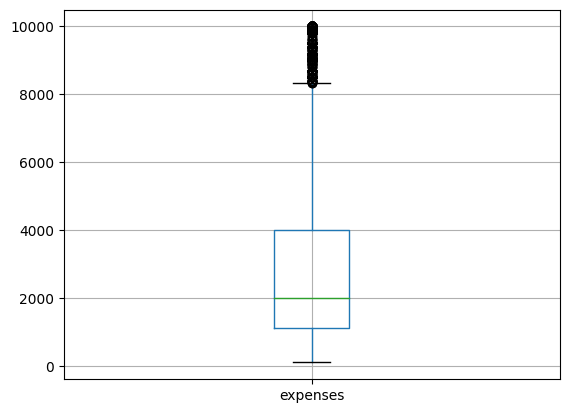

In [5]:
mask_expenses_max_min = data.expenses.between(100, 10000)
df = pd.DataFrame(data[mask_expenses_max_min],
                  columns=['expenses'])
boxplot = df.boxplot(column=['expenses'])  


In [6]:
mask_expenses_max_min = data.expenses.between(100, 7000)
display(data[mask_expenses_max_min].groupby('property_type').agg({'expenses':['count', 'mean', 'max', 'min']}))

expenses                            
                 count         mean     max    min
property_type                                     
PH                 299   910.006689  6000.0  100.0
apartment         9484  2160.670392  7000.0  100.0
house             1699  4132.544438  7000.0  100.0
store              323  1926.501548  7000.0  100.0

Lo que se observa es que existen valores mínimos y máximos muy alejados de la realidad.

Vamos a categorizar esta columna para tener rangos:

    0 -> Sin Expensas
    1 -> Expensas Bajas
    2 -> Expensas Normales
    3 -> Expensas Altas

Para ello tenemos que buscar los valores límites de cada categoría independizados por `property_type`.

In [7]:
max = 7000
mitad = max / 2
un_cuarto = max / 4
tres_cuartos = max * 3/4

# Compruebo en que cuartil se encuentra y pongo su columna a 1
print(un_cuarto)
print(mitad)
print(tres_cuartos)
print(max)

1750.0
3500.0
5250.0
7000


ahora que tenemos los valores limite, vamos a agregarlos en una columna nueva.

    0 -> Sin Expensas (expenses = 0]
    1 -> Expensas Bajas (0 < expenses <= un_cuarto]
    2 -> Expensas Normales (un_cuarto < expenses <= tres_cuartos]
    3 -> Expensas Altas (tres_cuartos < expenses)

In [8]:
def get_category(value):
    if value == 0:
        return 'Sin Expensas'
    elif value <= un_cuarto:
        return 'Expensas Bajas'
    elif value <= tres_cuartos:
        return 'Expensas Normales'
    else:
        return 'Expensas Altas'

data['expenses_category'] = data.apply(lambda x: get_category(x.expenses), axis=1)

In [9]:
data[['expenses', 'expenses_category']].sample(5, random_state=1212)

,expenses,expenses_category
38355,0.0,Sin Expensas
99369,0.0,Sin Expensas
919,0.0,Sin Expensas
109046,0.0,Sin Expensas
77917,2500.0,Expensas Normales


In [10]:
display(data.groupby('expenses_category').size())

expenses_category
Expensas Altas         2254
Expensas Bajas         6528
Expensas Normales      5480
Sin Expensas         106958
dtype: int64

In [15]:
#display(data.groupby('property_type').agg({'expenses_category':['count']}))
display(data[['property_type','expenses_category']].value_counts().sort_index())

property_type  expenses_category
PH             Expensas Altas           1
               Expensas Bajas         306
               Expensas Normales       41
               Sin Expensas          5403
apartment      Expensas Altas        1353
               Expensas Bajas        5641
               Expensas Normales     4210
               Sin Expensas         59861
house          Expensas Altas         862
               Expensas Bajas         330
               Expensas Normales     1116
               Sin Expensas         37960
store          Expensas Altas          38
               Expensas Bajas         251
               Expensas Normales      113
               Sin Expensas          3734
dtype: int64